In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

sns.set()

### 데이터셋 준비

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)
data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
# 수익률 계산
rets = data.pct_change().fillna(0)

In [4]:
# 색깔 팔레트
pal = sns.color_palette('Spectral', len(tickers))

### 역변동성 포트폴리오 최적화 알고리즘

In [5]:
# 각 자산별 변동성 계산
vol = rets.std() * np.sqrt(12)

# 역변동성 계산
inv_vol = 1 / vol

# 역변동성을 비중으로 하는 가중치 산출
weights = inv_vol / inv_vol.sum()

In [6]:
weights

XLB    0.096812
XLE    0.066660
XLF    0.097639
XLI    0.103363
XLK    0.107444
XLP    0.155339
XLU    0.134553
XLV    0.137189
XLY    0.101001
dtype: float64

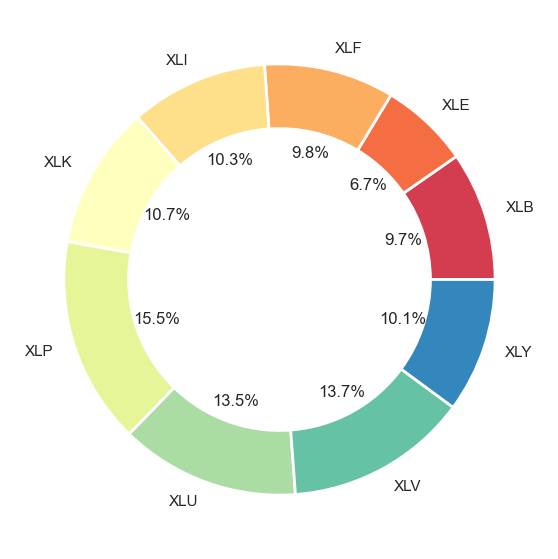

In [7]:
# EMV 가중치 데이터프레임 생성
weights_df = pd.Series(np.round(weights, 4), index=tickers)
weights_df = weights_df[weights_df > 0]

# 파이차트 시각화
plt.figure(figsize=(7, 7))
wedgeprops = {
    'width': 0.3,
    'edgecolor': 'w',
    'linewidth': 2
}

plt.pie(weights_df, labels=weights_df.index, autopct='%.1f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

In [8]:
# EMV 포트폴리오 가중치 계산 함수
def get_emv_weights(cov):
    vol = np.diag(cov)
    inv_vol = 1 / vol
    weights = inv_vol / inv_vol.sum()
    return weights

In [9]:
# 빈 데이터프레임 생성
emv_w_df = pd.DataFrame().reindex_like(rets)

# 공분산행렬의 3차원 배열생성
cov = rets.rolling(12).cov().fillna(0) * 12
cov = cov.values.reshape(int(cov.shape[0] / cov.shape[1]), cov.shape[1], cov.shape[1])

# EMV 가중치 산출
for i in range(12, len(emv_w_df)):
    emv_w_df.iloc[i] = get_emv_weights(cov[i - 1])

Text(0, 0.5, 'Weights')

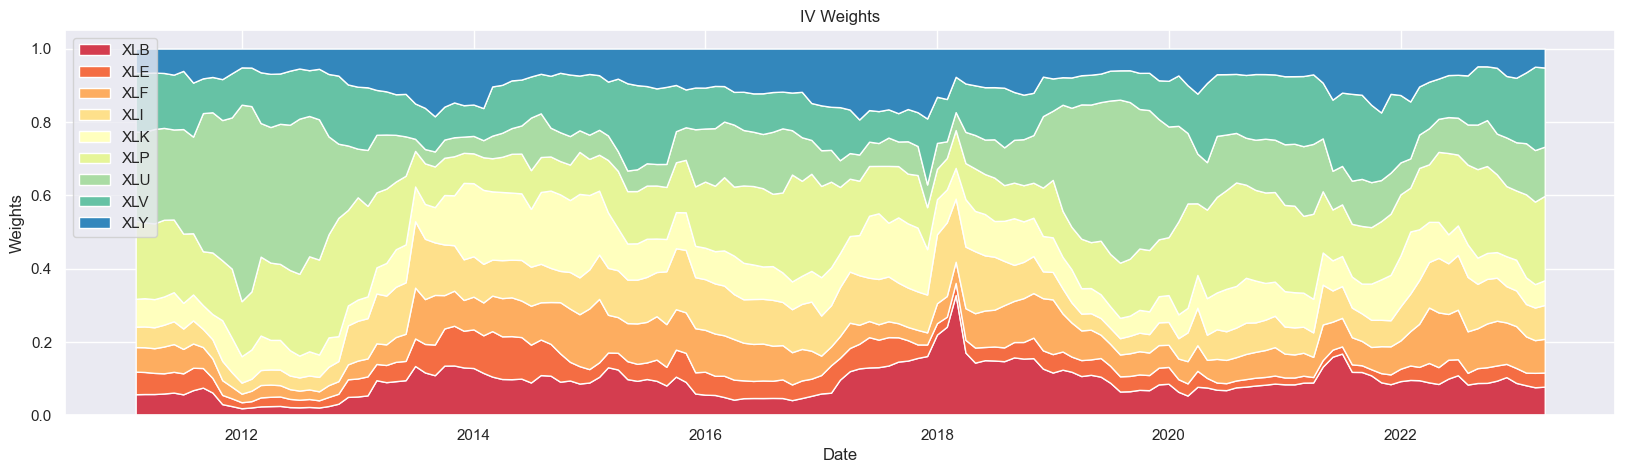

In [10]:
# 시계열 가중치 플랏 시각화
plt.figure(figsize=(20, 5))
plt.stackplot(emv_w_df.index, emv_w_df.T, labels=emv_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('IV Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

Text(0.5, 1.0, 'IV Backtest')

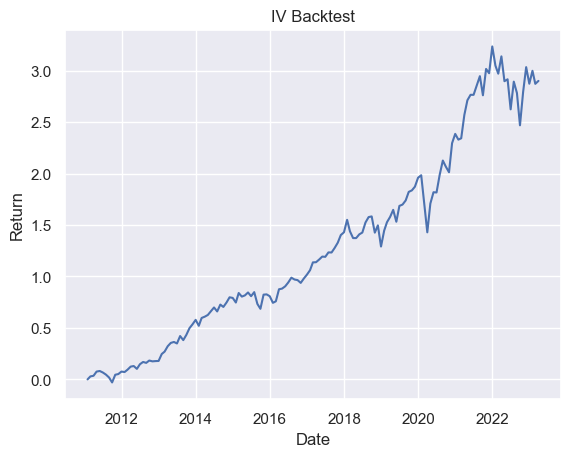

In [11]:
# EMV 포트폴리오 수익률
port_rets = emv_w_df.shift() * rets
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

# 백테스팅 시각화
plt.plot(port_cum_rets.iloc[12:])
plt.xlabel('Date')
plt.ylabel('Return')
plt.title('IV Backtest')
